In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install neurokit2
!pip install catboost
!pip install lightgbm
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
from statistics import mean
from scipy import stats
import neurokit2 as nk
import numpy as np
import numpy 

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import KMeansSMOTE
from collections import Counter
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE 
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier

# xgboost для классификации
from xgboost import XGBClassifier

In [ ]:
xl_df = pd.read_csv('/content/gdrive/MyDrive/ЭКГ/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv', index_col='ecg_id')
xl_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21837 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21837 non-null  float64
 1   age                           21748 non-null  float64
 2   sex                           21837 non-null  int64  
 3   height                        6983 non-null   float64
 4   weight                        9429 non-null   float64
 5   nurse                         20328 non-null  float64
 6   site                          21819 non-null  float64
 7   device                        21837 non-null  object 
 8   recording_date                21837 non-null  object 
 9   report                        21837 non-null  object 
 10  scp_codes                     21837 non-null  object 
 11  heart_axis                    13332 non-null  object 
 12  infarction_stadium1           5626 non-null   object 
 13  i

In [ ]:
xl_df.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


## Обработка вср

In [ ]:

def lenR_R1(rpeaks,ecg_data_path,ecg_signal):
  #_, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=D)
  R=0
  l=[]
  Rmax=ecg_signal[rpeaks['ECG_R_Peaks'][0]]
  Rmin=ecg_signal[rpeaks['ECG_R_Peaks'][0]]
  for i in range(0,(len(rpeaks['ECG_R_Peaks'])-1)):
    R = ((list(rpeaks['ECG_R_Peaks'])[i+1]) - (list(rpeaks['ECG_R_Peaks'])[i]))*(1/500)
    l.append(R)
  for i in range(1,(len(rpeaks['ECG_R_Peaks']))):
    Rmax = max(ecg_signal[rpeaks['ECG_R_Peaks'][i]],Rmax)
    Rmin = min(ecg_signal[rpeaks['ECG_R_Peaks'][i]],Rmin)
  return l ,Rmax ,Rmin

def spektral_metod(ecg_data_path,D):
  rpeaks=pd.DataFrame()
  Zone=['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
  ecg_signal = pd.read_csv("/content/gdrive/MyDrive/data/data500(I)/"+str(ecg_data_path)+".csv")['I']
  ecg_signal.head()
  _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=D)
  l,Rmax ,Rmin = lenR_R1(rpeaks,ecg_data_path,ecg_signal)
  l=list(filter(None, l))
  new_row = pd.Series(data={'СКО':None,'CV':None,'skewness':None,'kurtosis':None ,'RMSDD':None , 'NN5O':None,'pNN5O':None,'SDSD':None,'Rmax':None,'Rmin':None ,'min_signal':None,'Rmax-min_signal':None}, name=ecg_data_path)
  if len(list(filter(None, l))) == 0 and len(np.diff(l)) == 0 : 
      print("Невозможно выделить RR",ecg_data_path)    
      return new_row
  if len(np.diff(list(filter(None, l)))) < 2  : 
    plot = nk.events_plot(rpeaks['ECG_R_Peaks'], ecg_signal)
    print("Мало RR",ecg_data_path)
    return new_row   
  M = mean(l) #среднее значение интервалов RR;
  СКО = np.std(l)
  CV=(СКО/M)*100
  skewness = stats.skew(l, bias=False)#Коэффициент асимметрии
  kurtosis =stats.kurtosis(l, bias=False)#Коэффициент эксцесса
  RMSDD = np.sqrt(sum(pow (np.diff(l),2))/len (l))
  NN5O = len(np.diff(l)[abs(np.diff(l)>0.50)])
  pNN5O=100.0*len(np.diff(l)[abs(np.diff(l) >0.50)])/len(np.diff(l))
  SDSD=np.sqrt(sum((np.diff(l)-sum(np.diff(l))/ (len(l)-1))**2/(len(l)-2)))
  min_signal=min(list(ecg_signal))
  new_row = pd.Series(data={'СКО':СКО*1000,'CV':CV,'skewness':skewness,'kurtosis':kurtosis ,'RMSDD':RMSDD*1000 , 'NN5O':NN5O,'pNN5O':pNN5O,'SDSD':SDSD ,'Rmax':Rmax,'Rmin':Rmin,'min_signal':min_signal,'Rmax-min_signal':Rmax-min_signal}, name=(ecg_data_path))

  #print("Cреднее квадратическое отклонение ",СКО,"мс")
  #print("Коэффициент вариации ",CV,"%")
  #print("Коэффициент асимметрии ",skewness,"  & Коэффициент эксцесса ",kurtosis)
  #print("RMSSD ",RMSDD,"мс")
  #print("NN5O — ",NN5O,"количиство пар","pNN5O —",pNN5O,"%")
  #print("SDSD ",SDSD)
  #return(СКО,CV,skewness,kurtosis,RMSDD,NN5O,pNN5O,SDSD)  
  return new_row

spektral_metod(1,500)

СКО                16.944353
CV                  1.802591
skewness            0.035880
kurtosis           -1.030679
RMSDD              22.509257
NN5O                0.000000
pNN5O               0.000000
SDSD                0.025066
Rmax                0.519478
Rmin                0.441581
min_signal         -0.102287
Rmax-min_signal     0.621765
Name: 1, dtype: float64

In [ ]:
data = {'СКО':[],
     'CV':[],
     'skewness':[],
     'kurtosis':[],
     'RMSDD':[],
     'NN5O':[],
     'pNN5O':[],
     'SDSD':[],
     'Rmax':[],
     'Rmin':[],
     'min_signal':[],
    'Rmax-min_signal':[]
     }

#create dataframe
dp = pd.DataFrame(data)
D=500
i=1
n = (len(xl_df["patient_id"]))
print(n)
while i < n+1: 
  new_row = spektral_metod(i,D)
  dp = dp.append(new_row, ignore_index=False)
  i=i+1

dp.to_csv("/content/gdrive/MyDrive/data/"+"dp"+".csv")

In [ ]:
dp = pd.read_csv("/content/gdrive/MyDrive/data/"+"dp"+".csv")
dp.head(5)

,Unnamed: 0,СКО,CV,skewness,kurtosis,RMSDD,NN5O,pNN5O,SDSD,Rmax,Rmin,min_signal,Rmax-min_signal
0,1,16.944353,1.802591,0.035880,-1.030679,22.509257,0.0,0.0,0.025066,0.519478,0.441581,-0.102287,0.621765
1,2,76.993506,6.120311,0.210076,-1.940373,50.426750,0.0,0.0,0.054899,0.548533,0.042048,-0.240243,0.788776
2,3,18.517926,1.969061,0.530010,-0.679705,15.534907,0.0,0.0,0.017019,0.662726,0.466819,-0.112846,0.775572
3,4,43.702223,5.459056,-0.033127,-0.393498,33.742339,0.0,0.0,0.035456,0.397030,0.310811,-0.513963,0.910993
4,5,48.490824,5.356918,-0.002690,-1.079496,54.192250,0.0,0.0,0.060175,0.357298,0.310691,-0.213613,0.570912


## Обработка сигнала - пики

In [ ]:
def plot_signal(rpeaks,waves_dwt,ecg_signal):  
  plot = nk.events_plot([rpeaks['ECG_R_Peaks'][0:2],
                         waves_dwt['ECG_P_Onsets'][0:2],
                         waves_dwt['ECG_P_Peaks'][0:2],
                         waves_dwt['ECG_Q_Peaks'][0:2],
                         waves_dwt['ECG_S_Peaks'][0:2],
                         waves_dwt['ECG_T_Offsets'][0:2],
                         waves_dwt['ECG_T_Peaks'][0:2]
                         ], ecg_signal[500:1500])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


P_min         0.013001
P_max         0.157556
Q            -0.082978
S            -0.460277
T_min         0.157556
T_max         0.185359
max_signal    0.610386
Name: 16396, dtype: float64

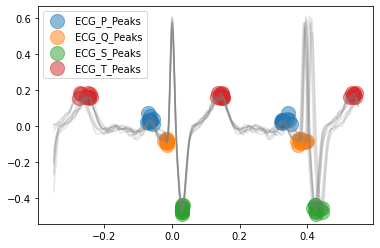

In [ ]:
def min_sig(l,ecg_signal):
  min =10
  for i in l:
    if i > 0:
      if ecg_signal[i] < min: min =ecg_signal[i]
  return min
def max_sig(l,ecg_signal):
  max =-10
  for i in l:
    if i > 0:
      if ecg_signal[i] > max: max =ecg_signal[i]
  return max
def mean_sig(l,ecg_signal):
  mean_l =[]
  for i in l:
    if i > 0 :
      mean_l.append(ecg_signal[i])
  if len(mean_l)>0 : 
    return mean(mean_l)
  else : return None

def PQST(ecg_data_path,D, show=True):
  ecg_signal = pd.read_csv("/content/gdrive/MyDrive/data/data500(I)/"+str(ecg_data_path)+".csv")['I']
  _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=D)
  rpeaks['ECG_R_Peaks']= rpeaks['ECG_R_Peaks'][:len(rpeaks['ECG_R_Peaks'])-1]
  rpeaks['ECG_R_Peaks']=rpeaks['ECG_R_Peaks'][np.logical_not(np.isnan(rpeaks['ECG_R_Peaks']))]
  if len(rpeaks['ECG_R_Peaks'])< 4 :
    new_row = pd.Series(data={'P_min':None,'P_max':None,'Q':None ,'S': None,'T_min':None,'T_max':None,'max_signal':max(ecg_signal)}, name=(ecg_data_path))
    return new_row
  signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="peak", show_type='peaks',show=show)
  # Visualize P-wave boundaries
  signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="peak", show_type='bounds_P')
  # Visualize R-wave boundaries
  signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="cwt", show_type='bounds_R')
  # visualize T-wave boundaries ?method="peak" ?method="dwt" , method="cwt"
  signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="cwt", show_type='bounds_T')
  #if show:
  #  plot_signal(rpeaks,waves_dwt,ecg_signal)
  if len(waves_dwt['ECG_P_Peaks'])>0:
    P_min ,P_max = min_sig(waves_dwt['ECG_P_Peaks'],ecg_signal),max_sig(waves_dwt['ECG_P_Peaks'],ecg_signal)
  else :
    P_min ,P_max = None,None
  if len(waves_dwt['ECG_T_Peaks'])>0:
    T_min,T_max = min_sig(waves_dwt['ECG_T_Peaks'],ecg_signal),max_sig(waves_dwt['ECG_T_Peaks'],ecg_signal)
  else :
    T_min,T_max = None,None
  if len(waves_dwt['ECG_Q_Peaks'])>0 :Q=mean_sig(waves_dwt['ECG_Q_Peaks'],ecg_signal)
  else:Q= None
  if len(waves_dwt['ECG_S_Peaks'])>0 :S=mean_sig(waves_dwt['ECG_S_Peaks'],ecg_signal)
  else:S= None
  max_signal=max(ecg_signal)
  new_row = pd.Series(data={'P_min':P_min,'P_max':P_max,'Q':Q ,'S': S,'T_min':T_min,'T_max':T_max,'max_signal':max_signal}, name=(ecg_data_path))
  return new_row
D=500
PQST(16396,D, show=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.p

,P_min,P_max,Q,S,T_min,T_max,max_signal
1,-0.012875,0.159522,-0.052145,-0.063619,0.123200,0.159522,0.519478
2,0.021315,0.402162,-0.064429,-0.185869,0.373818,0.438494,0.548533
3,-0.024220,0.202930,-0.083473,-0.066874,0.198009,0.228996,0.662726
4,-0.003560,0.324233,-0.075022,-0.460960,0.272816,0.324233,0.397030
5,-0.009723,0.175682,-0.058396,-0.167162,0.155644,0.175682,0.357298


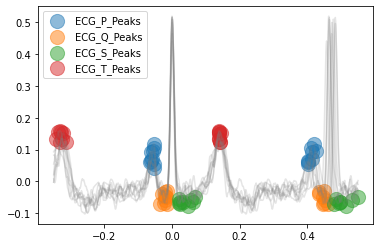

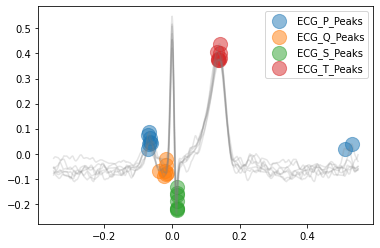

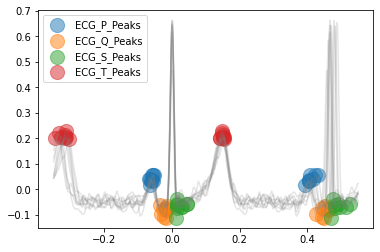

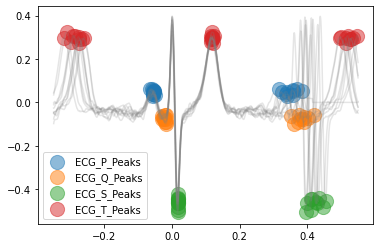

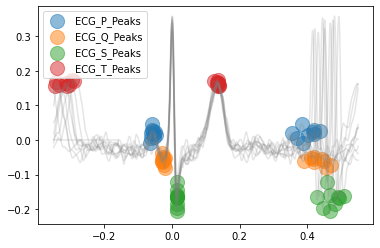

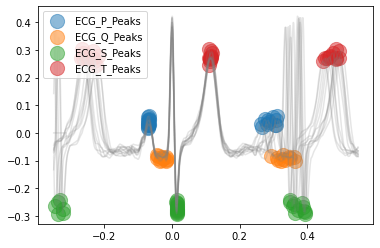

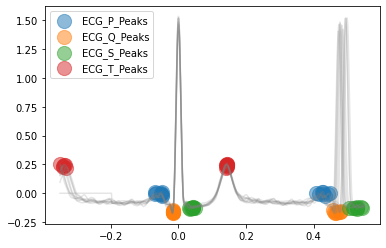

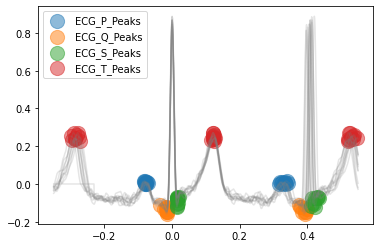

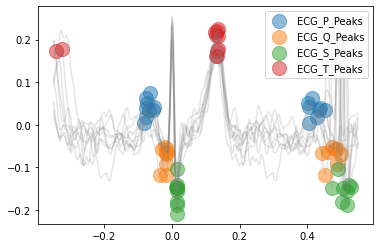

In [ ]:
xl_df = pd.read_csv('/content/gdrive/MyDrive/ЭКГ/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv', index_col='ecg_id')
data = {'P_min':[],
     'P_max':[],
     'Q':[],
     'S':[],
     'T_min':[],
     'T_max':[],
     'max_signal':[]
     }

#create dataframe
PQRS_peak = pd.DataFrame(data)
D=500
i=1
n = (len(xl_df["patient_id"]))
while i < 10: 
  new_row = PQST(i,D)
  PQRS_peak = PQRS_peak.append(new_row, ignore_index=False)
  i=i+1
PQRS_peak.head(5)

In [ ]:
PQRS_peak.to_csv("/content/gdrive/MyDrive/data/"+"PQRS_peak"+".csv")

In [ ]:
def inter1(A,B):
  i=0
  l=[]
  for i in A:
    for j in B:
      if i<j and i+500>j:
        l.append(j-i)
  return l 

def len_P_T_peaks(ecg_data_path,D):
  ecg_signal = pd.read_csv("/content/gdrive/MyDrive/data/data500(I)/"+str(ecg_data_path)+".csv")['I']
  _, rpeaks = nk.ecg_peaks(ecg_signal, sampling_rate=D)
  rpeaks['ECG_R_Peaks']= rpeaks['ECG_R_Peaks'][:len(rpeaks['ECG_R_Peaks'])-1]
  rpeaks['ECG_R_Peaks']=rpeaks['ECG_R_Peaks'][np.logical_not(np.isnan(rpeaks['ECG_R_Peaks']))]
  if len(rpeaks['ECG_R_Peaks'])< 3 :
    new_row = pd.Series(data={"min_PQ_inter":None,"max_PQ_inter":None,"min_ST_inter":None,"max_ST_inter":None,"min_signal":min(ecg_signal)}, name=(ecg_data_path))
    return new_row
  signal_dwt, waves_dwt = nk.ecg_delineate(ecg_signal, rpeaks, sampling_rate=1000, method="peak", show_type='peaks')#"cwt"
  PQ=inter1(waves_dwt["ECG_P_Onsets"],waves_dwt["ECG_Q_Peaks"])
  ST=inter1(waves_dwt["ECG_S_Peaks"],waves_dwt["ECG_T_Offsets"])
  if len(PQ) <1: PQ =[0]
  if len(ST) <1: ST =[0]
  new_row = pd.Series(data={"min_PQ_inter":min(PQ),"max_PQ_inter":max(PQ),"min_ST_inter":min(ST),"max_ST_inter":max(ST),"min_signal":min(ecg_signal)}, name=(ecg_data_path))
  return new_row


len_P_T_peaks(461,500)

min_PQ_inter      0.000000
max_PQ_inter      0.000000
min_ST_inter     84.000000
max_ST_inter    208.000000
min_signal       -0.221419
Name: 461, dtype: float64

In [ ]:
xl_df = pd.read_csv('/content/gdrive/MyDrive/ЭКГ/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv', index_col='ecg_id')
data={"min_PQ_inter":[],"max_PQ_inter":[],"min_ST_inter":[],"max_ST_inter":[],"min_signal":[]}

#create dataframe
PT_peak = pd.DataFrame(data)
D=500
i=1
n = (len(xl_df["patient_id"]))
while i < 5: 
  new_row = len_P_T_peaks(i,D)
  PT_peak  = PT_peak.append(new_row, ignore_index=False)
  i=i+1
PT_peak.head(5)

,min_PQ_inter,max_PQ_inter,min_ST_inter,max_ST_inter,min_signal
1,56.0,218.0,108.0,218.0,-0.102287
2,55.0,280.0,159.0,167.0,-0.240243
3,55.0,169.0,134.0,302.0,-0.112846
4,61.0,489.0,132.0,146.0,-0.513963


## Обзор параметров

 - 0)   patient_id                     - id пациента
 - 1)   age                            - возраст
 - 2)   sex                            - пол
 - 3)   height                         - рост
 - 4)   weight                         - вес
 - 5)   nurse                          - вовлеченная медсестра 
 - 6)   site                           - место записи
 - 7)   device                         - записывающее устроство
 - 8)   recording_date                 - дата и время записи
 - 9)   report                         - отчёт
 - 10)  scp_codes                      - диагностический код (в виде словаря)
 - 11)  heart_axis                     - ось сердца
 - 12)  infarction_stadium1            - стадии инфаркта
 - 13)  infarction_stadium2            - стадии инфаркта (сек)
 - 14)  validated_by                   - подтверждающий кардиолог
 - 15)  second_opinion                 - флаг для второго (отклоняющегося) мнения
 - 16)  initial_autogenerated_report   - первоначальный автоматически сгенерированный отчет устройством ЭКГ
 - 17)  validated_by_human             - проверенный человеком
 - 18)  baseline_drift                 - дрейф изолинии
 - 19)  static_noise                   - статический шум
 - 20)  burst_noise                    - взрывной шум
 - 21)  electrodes_problems            - проблемы с электродами
 - 22)  extra_beats                    - дополнительные удары
 - 23)  pacemaker                      - кардиостимулятор
 - 24)  strat_fold                     - предполагаемы стратифицированные выборки
 - 25)  filename_lr                    - путь к файлу 100Гц
 - 26)  filename_hr                    - путь к файлу 500Гц

Проверим размерность

In [ ]:
xl_df = pd.read_csv('/content/gdrive/MyDrive/ЭКГ/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv', index_col='ecg_id')
dp = pd.read_csv("/content/gdrive/MyDrive/data/"+"dp"+".csv",index_col="Unnamed: 0")
xl_df.columns
len(xl_df),len(dp)

(21837, 21837)

In [ ]:
PQRS_peak = pd.read_csv("/content/gdrive/MyDrive/data/PQRS_peak.csv",index_col="Unnamed: 0")
PQRS_peak.columns

Index(['P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'min_signal', 'maxmin'],
      dtype='object')

In [ ]:

dp[['P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'min_signal', 'maxmin']] = PQRS_peak[['P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'min_signal', 'maxmin']]
dp[['age', 'sex','scp_codes']]=xl_df[['age', 'sex','scp_codes']]
       #'heart_axis'
dp= dp.dropna()
dp.head(4)

,СКО,CV,skewness,kurtosis,RMSDD,NN5O,pNN5O,SDSD,Rmax,Rmin,...,T_max,max_signal,min_PQ_inter,max_PQ_inter,min_ST_inter,max_ST_inter,maxmin,age,sex,scp_codes
1,16.944353,1.802591,0.035880,-1.030679,22.509257,0.0,0.0,0.025066,0.519478,0.441581,...,0.159522,0.519478,56.0,223.0,108.0,218.0,0.621765,56.0,1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"
2,76.993506,6.120311,0.210076,-1.940373,50.426750,0.0,0.0,0.054899,0.548533,0.042048,...,0.438494,0.548533,43.0,207.0,159.0,167.0,0.788776,19.0,0,"{'NORM': 80.0, 'SBRAD': 0.0}"
3,18.517926,1.969061,0.530010,-0.679705,15.534907,0.0,0.0,0.017019,0.662726,0.466819,...,0.228996,0.662726,55.0,169.0,134.0,302.0,0.775572,37.0,1,"{'NORM': 100.0, 'SR': 0.0}"
4,43.702223,5.459056,-0.033127,-0.393498,33.742339,0.0,0.0,0.035456,0.397030,0.310811,...,0.324233,0.397030,61.0,489.0,132.0,146.0,0.910993,24.0,0,"{'NORM': 100.0, 'SR': 0.0}"


In [ ]:
display(dp.head(),
        dp.info(),
        dp.describe(),
        dp.shape)
dp.duplicated().sum()#

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21730 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   СКО              21730 non-null  float64
 1   CV               21730 non-null  float64
 2   skewness         21730 non-null  float64
 3   kurtosis         21730 non-null  float64
 4   RMSDD            21730 non-null  float64
 5   NN5O             21730 non-null  float64
 6   pNN5O            21730 non-null  float64
 7   SDSD             21730 non-null  float64
 8   Rmax             21730 non-null  float64
 9   Rmin             21730 non-null  float64
 10  min_signal       21730 non-null  float64
 11  Rmax-min_signal  21730 non-null  float64
 12  P_min            21730 non-null  float64
 13  P_max            21730 non-null  float64
 14  Q                21730 non-null  float64
 15  S                21730 non-null  float64
 16  T_min            21730 non-null  float64
 17  T_max       

,СКО,CV,skewness,kurtosis,RMSDD,NN5O,pNN5O,SDSD,Rmax,Rmin,...,T_max,max_signal,min_PQ_inter,max_PQ_inter,min_ST_inter,max_ST_inter,maxmin,age,sex,scp_codes
1,16.944353,1.802591,0.035880,-1.030679,22.509257,0.0,0.0,0.025066,0.519478,0.441581,...,0.159522,0.519478,56.0,223.0,108.0,218.0,0.621765,56.0,1,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}"
2,76.993506,6.120311,0.210076,-1.940373,50.426750,0.0,0.0,0.054899,0.548533,0.042048,...,0.438494,0.548533,43.0,207.0,159.0,167.0,0.788776,19.0,0,"{'NORM': 80.0, 'SBRAD': 0.0}"
3,18.517926,1.969061,0.530010,-0.679705,15.534907,0.0,0.0,0.017019,0.662726,0.466819,...,0.228996,0.662726,55.0,169.0,134.0,302.0,0.775572,37.0,1,"{'NORM': 100.0, 'SR': 0.0}"
4,43.702223,5.459056,-0.033127,-0.393498,33.742339,0.0,0.0,0.035456,0.397030,0.310811,...,0.324233,0.397030,61.0,489.0,132.0,146.0,0.910993,24.0,0,"{'NORM': 100.0, 'SR': 0.0}"
5,48.490824,5.356918,-0.002690,-1.079496,54.192250,0.0,0.0,0.060175,0.357298,0.310691,...,0.175682,0.357298,54.0,499.0,151.0,266.0,0.570912,19.0,1,"{'NORM': 100.0, 'SR': 0.0}"


None

,СКО,CV,skewness,kurtosis,RMSDD,NN5O,pNN5O,SDSD,Rmax,Rmin,...,T_min,T_max,max_signal,min_PQ_inter,max_PQ_inter,min_ST_inter,max_ST_inter,maxmin,age,sex
count,21730.000000,21730.000000,21730.000000,21730.000000,21730.000000,21730.000000,21730.000000,21730.000000,21730.000000,21730.000000,...,21730.000000,21730.000000,21730.000000,21730.000000,21730.000000,21730.00000,21730.000000,21730.000000,21730.000000,21730.000000
mean,59.322698,7.106397,-0.393780,1.339130,73.742950,0.100782,1.106451,0.080940,0.692269,0.426873,...,0.112659,0.148709,0.695822,63.437184,390.699540,101.11896,344.128716,0.910587,59.836079,0.477543
std,76.914547,8.573082,1.244726,3.634274,111.400097,0.419687,4.625272,0.127659,0.383687,0.338771,...,0.507063,0.537843,0.392338,23.832187,130.747109,41.75391,134.677101,0.591490,16.948952,0.499507
min,0.000000,0.000000,-4.313801,-3.045847,0.000000,0.000000,0.000000,0.000000,-0.032802,-0.840680,...,-0.888749,-10.000000,0.061335,0.000000,0.000000,1.00000,44.000000,0.146380,2.000000,0.000000
25%,13.163364,1.576656,-0.858360,-0.972398,12.504545,0.000000,0.000000,0.013383,0.464659,0.120927,...,0.014723,0.097167,0.467180,49.000000,242.000000,76.00000,217.000000,0.645596,50.000000,0.000000
50%,29.780887,3.479094,-0.140948,-0.152493,29.441004,0.000000,0.000000,0.032154,0.650347,0.414437,...,0.077563,0.154454,0.652373,61.000000,470.000000,107.00000,339.000000,0.850394,62.000000,0.000000
75%,74.578270,9.010667,0.359253,1.981053,85.957984,0.000000,0.000000,0.092810,0.865067,0.644198,...,0.148487,0.223039,0.867631,74.000000,491.000000,133.00000,486.000000,1.089975,72.000000,1.000000
max,2078.098831,107.925154,4.673600,23.335820,3563.835715,6.000000,60.000000,5.030110,20.207867,2.954439,...,10.000000,17.713866,20.207867,222.000000,499.000000,248.00000,499.000000,34.735272,95.000000,1.000000


(21730, 27)

16

## Обработка диагнозов


In [ ]:
xl_df = pd.read_csv('/content/gdrive/MyDrive/ЭКГ/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv', index_col='ecg_id')
dp = pd.read_csv("/content/gdrive/MyDrive/data/"+"dp"+".csv",index_col="Unnamed: 0")
PQRS_peak = pd.read_csv("/content/gdrive/MyDrive/data/PQRS_peak.csv",index_col="Unnamed: 0")
dp[['P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'min_signal', 'maxmin']] = PQRS_peak[['P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'min_signal', 'maxmin']]
dp[['age', 'sex','scp_codes',]]=xl_df[['age', 'sex','scp_codes']]
dp= dp.dropna()
dp.drop_duplicates(inplace=True)#Удаляем дубляж
dp.reset_index(inplace=True, drop=True)
dp.shape
dp['scp_codes'].value_counts()#Дисбаланс-баланс

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


{'NORM': 100.0, 'SR': 0.0}                                                               6140
{'NORM': 80.0, 'SR': 0.0}                                                                 722
{'NDT': 100.0, 'SR': 0.0}                                                                 635
{'LAFB': 100.0, 'SR': 0.0}                                                                277
{'PACE': 100.0}                                                                           268
                                                                                         ... 
{'IMI': 100.0, 'IVCD': 100.0, 'SR': 0.0}                                                    1
{'ILMI': 80.0, 'ABQRS': 0.0}                                                                1
{'AMI': 35.0, 'RAO/RAE': 100.0, 'LAFB': 100.0, 'VCLVH': 0.0, 'SR': 0.0}                     1
{'CRBBB': 100.0, 'LPFB': 100.0, '1AVB': 100.0, 'RVH': 100.0, 'ABQRS': 0.0, 'SR': 0.0}       1
{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'STACH': 0.0}    

In [ ]:
scp_statements1 = pd.read_csv('/content/gdrive/MyDrive/ЭКГ/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/scp_statements.csv')
scp_statements = list(scp_statements1["Unnamed: 0"])
df_cod=dp["scp_codes"]
scp_statements3 = pd.DataFrame()
scp_statements3[["Unnamed: 0","description","diagnostic_class","diagnostic_subclass","Statement Category","SCP-ECG Statement Description"]] = scp_statements1[["Unnamed: 0","description","diagnostic_class","diagnostic_subclass","Statement Category","SCP-ECG Statement Description"]]
print(scp_statements3["diagnostic_class"].value_counts())

MI      14
STTC    13
CD      11
HYP      5
NORM     1
Name: diagnostic_class, dtype: int64


In [ ]:
print(scp_statements3["diagnostic_subclass"].value_counts())

IMI          6
AMI          6
STTC         5
ISCA         4
_AVB         3
ISCI         2
LAFB/LPFB    2
NORM         1
SEHYP        1
ILBBB        1
WPW          1
RAO/RAE      1
RVH          1
LMI          1
CLBBB        1
LAO/LAE      1
LVH          1
CRBBB        1
NST_         1
IVCD         1
IRBBB        1
ISC_         1
PMI          1
Name: diagnostic_subclass, dtype: int64


Приведем к виду {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0} -> {'NORM', 'LVOLT', 'SR'}

In [ ]:
def del_symbol_l(scp_codes):
  str_scp_codes = "{"
  for i in scp_statements : 
    if i in scp_codes  != False:str_scp_codes =  str_scp_codes + "'" + str(i)+ "'" + ","
  str_scp_codes = str_scp_codes[:len(str_scp_codes)-1]+  "}"
  return str_scp_codes
i=0
k=0
while i < len(df_cod):
  df_cod[i] = del_symbol_l(df_cod[i])
  i=i+1
df_cod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


0                      {'NORM','LVOLT','SR'}
1                           {'NORM','SBRAD'}
2                              {'NORM','SR'}
3                              {'NORM','SR'}
4                              {'NORM','SR'}
                        ...                 
21709    {'NDT','LVH','PVC','VCLVH','STACH'}
21710                  {'NORM','ABQRS','SR'}
21711                         {'ISCAS','SR'}
21712                          {'NORM','SR'}
21713                          {'NORM','SR'}
Name: scp_codes, Length: 21714, dtype: object

In [ ]:
# вывести в лист все обьекты включающие это имя 
def del_symbol(scp_codes,klass):
  for i in klass : 
    if i in scp_codes  != False:
      return scp_codes
def del_symbol_0(Sl,df_cod):
  i=0
  l = []
  while i < len(df_cod):
    l.append(del_symbol(df_cod[i],Sl))
    i=i+1
  l_0 = pd.DataFrame()
  l_0["diagnostic"] = l
  l_0 = l_0.dropna()
  return l_0

Все кроме STTC можно заменить на diagnostic_subclass коды.

ISCI ,ISCA можео так же обьеденить

Заменяем кодами diagnostic_subclass существующие коды.

Получили

In [ ]:
df_cod.value_counts()

{'NORM','SR'}                                          7060
{'NDT','SR'}                                            635
{'IMI','ABQRS','SR'}                                    496
{'NORM','SARRH'}                                        339
{'LAFB','SR'}                                           298
                                                       ... 
{'ASMI','IVCD','PVC','SR'}                                1
{'NDT','IRBBB','AMI','AFIB'}                              1
{'DIG','LVH','ISC_','1AVB','PVC','LOWT','LPR','SR'}       1
{'ASMI','IRBBB','LAO/LAE','ABQRS','SARRH'}                1
{'NDT','LVH','PVC','VCLVH','STACH'}                       1
Name: scp_codes, Length: 4017, dtype: int64

Обьеденим некоторые коды 

In [ ]:
#Unn что заменять
#subclass на что заменять
def zamena(Unn,subclass,df_codd):
  i=0
  df_c = df_codd
  while i < len(df_c):
    for j in Unn : 
      if j in df_c[i] != False:
        df_k = df_c[i]
        df_c[i] = df_k.replace(j, subclass)
    i=i+1
  return df_c
# IMI AMI заменяем по категории 
Unn0 = pd.DataFrame()
Unn0 = scp_statements3[scp_statements1["Statement Category"] == 'Myocardial Infarction']        
df_c = zamena(list(Unn0["Unnamed: 0"]),'MI',df_cod)
Unn0 = pd.DataFrame()
Unn0 = scp_statements3[scp_statements1["Statement Category"] == 'ischemic ST-T changes compatible with subendocardial injury']        
df_c = zamena(list(Unn0["Unnamed: 0"]),'MI',df_c)
Unn0 = scp_statements3[scp_statements1["Statement Category"] == 'ischemic ST-T changes']        
df_c = zamena(list(Unn0["Unnamed: 0"]),'MI',df_c)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
scp_statements3["Statement Category"].value_counts().to_csv("/content/sample_data/scp1.csv")
scp1 = pd.read_csv("/content/sample_data/scp1.csv")
# 2,4,5,8,12
l=[]
for i in scp1["Unnamed: 0"]:
  df = pd.DataFrame({"l":[]})
  df["l"] = list(set(list(scp_statements3["diagnostic_subclass"][scp_statements3["Statement Category"] == i])))
  df=df.dropna()
  l.append(list(df["l"]))
scp1["Statement Category"] = l

scp1["Name"] = [[],["MI"],["BPG"],["STTC"],["I/N_S"],["ISC"],["MI"],[],["HYP"],["BPG"],[],["NORM"],["AO/AE"],["STTC"],[]]
scp1

,Unnamed: 0,Statement Category,Name
0,Statements related to impulse formation (abnor...,[],[]
1,Myocardial Infarction,"[PMI, AMI, IMI, LMI]",[MI]
2,Intraventricular and intra-atrial Conduction d...,"[CRBBB, WPW, ILBBB, IRBBB, IVCD, LAFB/LPFB, CL...",[BPG]
3,other ST-T descriptive statements,[STTC],[STTC]
4,Basic roots for coding ST-T changes and abnorm...,"[NST_, ISC_]",[I/N_S]
5,ischemic ST-T changes,"[ISCA, ISCI]",[ISC]
6,ischemic ST-T changes compatible with subendoc...,"[AMI, IMI]",[MI]
7,Statements related to ectopic rhythm abnormali...,[],[]
8,Ventricular Hypertrophy,"[SEHYP, RVH, LVH]",[HYP]
9,"Sinus node dysfunction, atrial and AV-conducti...",[_AVB],[BPG]


In [ ]:
l=[2,4,5,8,9,12]
for i in l:
  Unn0 = pd.DataFrame()
  Unn0 = scp_statements3[scp_statements1["Statement Category"] == scp1["Unnamed: 0"][i]]       
  df_c = zamena(list(Unn0["Unnamed: 0"]),scp1["Name"][i][0],df_c)

In [ ]:
scp_statements3["diagnostic_subclass"].value_counts().to_csv("/content/sample_data/scp.csv")
scp_statements4 = pd.read_csv("/content/sample_data/scp.csv")
list(scp_statements4["Unnamed: 0"])

['IMI',
 'AMI',
 'STTC',
 'ISCA',
 '_AVB',
 'ISCI',
 'LAFB/LPFB',
 'NORM',
 'SEHYP',
 'ILBBB',
 'WPW',
 'RAO/RAE',
 'RVH',
 'LMI',
 'CLBBB',
 'LAO/LAE',
 'LVH',
 'CRBBB',
 'NST_',
 'IVCD',
 'IRBBB',
 'ISC_',
 'PMI']

IMI / AMI уже обработанны .

STTC - другие описательные утверждения ST-T в которые входят неспецефические измемения QST характерные для разных видов заболеваний. 

ISCA/ISCI  - ischemic ST-T changes	, передние-боковые/нижние

_AVB - блокада I,II,III степени 
LAFB/LPFB - левая задняя блокада

In [ ]:
i=2
while i<len(scp_statements4["Unnamed: 0"]):
  Unn0 = pd.DataFrame()
  Unn0 = scp_statements3[scp_statements1["diagnostic_subclass"] == scp_statements4["Unnamed: 0"][i]]        
  df_c = zamena(list(Unn0["Unnamed: 0"]),list(Unn0["diagnostic_subclass"][0:1])[0],df_c)
  i=i+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Получили 2380 кодов . Все еще слишком много.

In [ ]:
df_c.value_counts()

{'NORM','SR'}                                     7060
{'BPG','SR'}                                       874
{'MI','ABQRS','SR'}                                727
{'STTC','SR'}                                      679
{'MI','SR'}                                        432
                                                  ... 
{'MI','BPG','MI','MI','ABQRS','PVC','SARRH'}         1
{'STTC','BPG','PVC','SARRH'}                         1
{'MI','HYP','I/N_S','BPG','MI','ABQRS','AFIB'}       1
{'BPG','BPG','MI','MI','SR'}                         1
{'STTC','HYP','PVC','VCHYP','STACH'}                 1
Name: scp_codes, Length: 2380, dtype: int64

In [ ]:
df_c.to_csv("/content/gdrive/MyDrive/data/"+"df_c"+".csv")

In [ ]:
#scp_statements5 = list(scp_statements4["Unnamed: 0"])
#for i in scp_statements[44:]:
#  scp_statements5.append(i)
l=[2,4,5,8,12]
scp_statements5 = list(scp_statements4["Unnamed: 0"])
for i in l:
  scp_statements5.append(scp1["Name"][i][0])
scp_statements5.append('MI')
scp_statements5.remove('_AVB')
scp_statements5.remove('AO/AE')
scp_statements5.remove('ISC')

In [ ]:
l=[2,4,5,8,12]
print(len(scp_statements5))
for i in scp_statements4["Unnamed: 0"][scp_statements1["Statement Category"] == scp1["Unnamed: 0"][12]] :
  scp_statements5.remove(str(i))
print(len(scp_statements5))

26
25


Удалим повтор кодов

In [ ]:
df_c1 = pd.read_csv("/content/gdrive/MyDrive/data/"+"df_c"+".csv")["scp_codes"]
from pandas.io.parsers.readers import read_csv
def del_symbol_q(scp_codes):
  str_scp_codes = "{"
  for i in scp_statements5 : 
    if i in scp_codes  != False:str_scp_codes =  str_scp_codes + "'" + str(i)+ "'" + ","

  str_scp_codes = str_scp_codes[:len(str_scp_codes)-1]+  "}"
  return str_scp_codes

i=0
print(len(df_c1))
while i < len(df_c1):
  if len(del_symbol_q(df_c1[i]))>1:
    df_c1[i] = del_symbol_q(df_c1[i])
  else:df_c1[i] = None
  i=i+1
print(len(df_c1))

21714
21714


Всего диагнозов получилось

In [ ]:
len(df_c1.value_counts())

40

Наглядно видно что имеет смысл брать первые 15 диагнозов 

In [ ]:
df_c1.value_counts()[:20]

{'NORM'}                      8811
{'MI'}                        3141
{'BPG'}                       1741
{'BPG','MI'}                  1547
{'STTC'}                      1119
{'I/N_S','HYP'}                620
{'I/N_S'}                      483
{'HYP'}                        444
{'NORM','BPG'}                 386
{'STTC','I/N_S'}               362
{'I/N_S','HYP','MI'}           348
{'I/N_S','MI'}                 250
{'STTC','BPG'}                 203
{'BPG','HYP'}                  200
{'NORM','I/N_S'}               181
{'HYP','MI'}                   175
{'STTC','MI'}                  169
{'BPG','I/N_S','HYP'}          157
{'BPG','I/N_S','HYP','MI'}     151
{'BPG','I/N_S','MI'}           119
Name: scp_codes, dtype: int64

Всего получилось 5 кодов из которых составляются диагнозы

In [ ]:
d=[]
d1=[]
df_c2 = pd.DataFrame(df_c1)
for i in scp_statements5:
  if len(df_c2[df_c2["scp_codes"] == "{"+"'"+str(i)+"'"+"}"]) > 0 :
    print(i,len(df_c2[df_c2["scp_codes"] == "{"+"'"+str(i)+"'"+"}"]))
    d.append(i)
d2 = ["other ST-T descriptive statements","normal ECG","Blockades","ST-T changes and abnormalities","Hypertrophy","Myocardial Infarction/ischemic"]

STTC 1119
NORM 8811
BPG 1741
I/N_S 483
HYP 444
MI 3141


Расшифровка

In [ ]:
dd = pd.DataFrame()
dd["scp_codes"] = d
dd["scp_Name"] = d2
dd

,scp_codes,scp_Name
0,STTC,other ST-T descriptive statements
1,NORM,normal ECG
2,BPG,Blockades
3,I/N_S,ST-T changes and abnormalities
4,HYP,Hypertrophy
5,MI,Myocardial Infarction/ischemic


In [ ]:
df_c1.to_csv("/content/gdrive/MyDrive/data/"+"df_c1"+".csv")

## Выберем первые 15 признаков и обозначим их цифрами для последующего обучения

In [ ]:
df_c1 = pd.read_csv("/content/gdrive/MyDrive/data/"+"df_c1"+".csv")

In [ ]:
xl_df = pd.read_csv('/content/gdrive/MyDrive/ЭКГ/data/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv', index_col='ecg_id')
dp = pd.read_csv("/content/gdrive/MyDrive/data/"+"dp"+".csv",index_col="Unnamed: 0")
PQRS_peak = pd.read_csv("/content/gdrive/MyDrive/data/PQRS_peak.csv",index_col="Unnamed: 0")
dp[['P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'min_signal', 'maxmin']] = PQRS_peak[['P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'min_signal', 'maxmin']]
dp[['age', 'sex','scp_codes',]]=xl_df[['age', 'sex','scp_codes']]
dp.drop_duplicates(inplace=True)#Удаляем дубляж
dp.reset_index(inplace=True, drop=True)
dp.shape
dp['scp_codes'].value_counts()[100:]#Дисбаланс-баланс
dp['scp_codes']=df_c1['scp_codes']
dp= dp.dropna()
dp.to_csv("/content/sample_data/"+"dp"+".csv")
dp = pd.read_csv("/content/sample_data/"+"dp"+".csv")

Выделим первые 15 диагнозов

In [ ]:
df_c1["scp_codes"].value_counts().to_frame()[0:15].to_csv("/content/gdrive/MyDrive/data/"+"df_c_100"+".csv")
df_c_100 = pd.read_csv("/content/gdrive/MyDrive/data/"+"df_c_100"+".csv")
i=0
while i < len(df_c_100):
  df_c_100["scp_codes"][i] = i
  i=i+1
df_c_100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Unnamed: 0,scp_codes
0,{'NORM'},0
1,{'MI'},1
2,{'BPG'},2
3,"{'BPG','MI'}",3
4,{'STTC'},4
5,"{'I/N_S','HYP'}",5
6,{'I/N_S'},6
7,{'HYP'},7
8,"{'NORM','BPG'}",8
9,"{'STTC','I/N_S'}",9


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
def f_0_(dp11,l,df_c_100): 
  q=-1
  dp1 = None
  for j in l:
    q=q+1
    if (dp11 == j) :
      return q
  return dp1

dp1=dp
l = df_c_100["Unnamed: 0"]
k=0
while k < len(dp1):
  dp1["scp_codes"][k] =f_0_(dp1["scp_codes"][k],l,df_c_100)
  k=k+1
dp1["scp_codes"].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


0     8763
1     3132
2     1734
3     1537
4     1114
5      618
6      479
7      443
8      382
9      360
10     348
11     249
13     200
12     200
14     178
Name: scp_codes, dtype: int64

In [ ]:
dp1.to_csv("/content/gdrive/MyDrive/data/"+"df_1_1"+".csv")

Преобразуем сигналы в зависимости от их интервала

In [ ]:
dp1 = pd.read_csv("/content/gdrive/MyDrive/data/"+"df_1_1"+".csv")
dp1= dp1.dropna()
dp= dp1
dp = dp.drop(columns =["Unnamed: 0.1"], axis = 1)
#19737
i=0
for i in dp["Unnamed: 0"]:
  dp["Rmax"][i] = dp["Rmax"][i]/dp["maxmin"][i]
  dp["Rmin"][i] = dp["Rmin"][i]/dp["maxmin"][i]
  dp["P_min"][i] = dp["P_min"][i]/dp["maxmin"][i]
  dp["P_max"][i] = dp["P_max"][i]/dp["maxmin"][i]
  dp["Q"][i] = dp["Q"][i]/dp["maxmin"][i]
  dp["S"][i] = dp["S"][i]/dp["maxmin"][i]
  dp["T_min"][i] = dp["T_min"][i]/dp["maxmin"][i]
  dp["T_max"][i] = dp["T_max"][i]/dp["maxmin"][i]

dp.columns

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dis

Index(['Unnamed: 0', 'СКО', 'CV', 'skewness', 'kurtosis', 'RMSDD', 'NN5O',
       'pNN5O', 'SDSD', 'Rmax', 'Rmin', 'min_signal', 'Rmax-min_signal',
       'P_min', 'P_max', 'Q', 'S', 'T_min', 'T_max', 'max_signal',
       'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter', 'max_ST_inter',
       'maxmin', 'age', 'sex', 'scp_codes'],
      dtype='object')

In [ ]:
dp = dp.drop(columns =["Rmax-min_signal"], axis = 1) # не имеет смысла 
dp = dp.drop(columns =["Unnamed: 0"], axis = 1)
dp.to_csv("/content/gdrive/MyDrive/data/"+"df_1_1.1"+".csv")

In [ ]:
dp.head(5)

,СКО,CV,skewness,kurtosis,RMSDD,NN5O,pNN5O,SDSD,Rmax,Rmin,...,T_max,max_signal,min_PQ_inter,max_PQ_inter,min_ST_inter,max_ST_inter,maxmin,age,sex,scp_codes
0,16.944353,1.802591,0.035880,-1.030679,22.509257,0.0,0.0,0.025066,0.835489,0.710206,...,0.256563,0.519478,56.0,223.0,108.0,218.0,0.621765,56.0,1,0.0
1,76.993506,6.120311,0.210076,-1.940373,50.426750,0.0,0.0,0.054899,0.695423,0.053307,...,0.555918,0.548533,43.0,207.0,159.0,167.0,0.788776,19.0,0,0.0
2,18.517926,1.969061,0.530010,-0.679705,15.534907,0.0,0.0,0.017019,0.854500,0.601904,...,0.295261,0.662726,55.0,169.0,134.0,302.0,0.775572,37.0,1,0.0
3,43.702223,5.459056,-0.033127,-0.393498,33.742339,0.0,0.0,0.035456,0.435821,0.341178,...,0.355911,0.397030,61.0,489.0,132.0,146.0,0.910993,24.0,0,0.0
4,48.490824,5.356918,-0.002690,-1.079496,54.192250,0.0,0.0,0.060175,0.625838,0.544202,...,0.307722,0.357298,54.0,499.0,151.0,266.0,0.570912,19.0,1,0.0


## Машинное обучение

In [4]:
dp = pd.read_csv("/content/gdrive/MyDrive/data/"+"df_1_1.1"+".csv").drop(columns =["Unnamed: 0"], axis = 1)
dp= dp.dropna()
dp.columns

Index(['СКО', 'CV', 'skewness', 'kurtosis', 'RMSDD', 'NN5O', 'pNN5O', 'SDSD',
       'Rmax', 'Rmin', 'min_signal', 'P_min', 'P_max', 'Q', 'S', 'T_min',
       'T_max', 'max_signal', 'min_PQ_inter', 'max_PQ_inter', 'min_ST_inter',
       'max_ST_inter', 'maxmin', 'age', 'sex', 'scp_codes'],
      dtype='object')

In [ ]:
dp['scp_codes'].value_counts()

0.0     8763
1.0     3132
2.0     1734
3.0     1537
4.0     1114
5.0      618
6.0      479
7.0      443
8.0      382
9.0      360
10.0     348
11.0     249
13.0     200
12.0     200
14.0     178
Name: scp_codes, dtype: int64

In [5]:
X, y = dp.drop(columns=['scp_codes']) , dp['scp_codes']
sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
X, y = sm.fit_resample(X, y)
sm = BorderlineSMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)#test_size=0.3 # random_state=1235

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)#test_size=0.3 # random_state=1235

In [7]:
from sklearn.metrics import f1_score
def f0(model , X_train, X_valid, y_train, y_valid):
  model.fit(X_train, y_train)
  print("score ",model.score(X_train, y_train))
  y_predict = model.predict(X_valid)
  print("f1_score micro ",f1_score(y_valid,y_predict, average='micro')) #"samples"
  print("f1_score macro ",f1_score(y_valid,y_predict, average='macro'))
  print("f1_score weighted ",f1_score(y_valid,y_predict, average='weighted'))

In [18]:
f0(CatBoostClassifier(verbose=0, n_estimators=100) , X_train, X_valid, y_train, y_valid)

score  0.8249877830265515
f1_score micro  0.7936652730267325
f1_score macro  0.7849999725800835
f1_score weighted  0.785858317408259


In [19]:
f0(LGBMClassifier(), X_train, X_valid, y_train, y_valid)

score  0.8853016235000272
f1_score micro  0.8501710376282782
f1_score macro  0.8476489376676682
f1_score weighted  0.8482630185347263


In [11]:
f0(XGBClassifier() , X_train, X_valid, y_train, y_valid)

score  0.5347016343595591
f1_score micro  0.5196756619789688
f1_score macro  0.4846740081293127
f1_score weighted  0.48587167981127377


In [ ]:
def obrabotka(model):
  model1=model
  X, y = dp.drop(columns=['scp_codes']) , dp['scp_codes']
  sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
  X, y = sm.fit_resample(X, y)
  sm = BorderlineSMOTE(random_state=42)
  X, y = sm.fit_resample(X, y)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)#test_size=0.3 # random_state=1235
  model.fit(X_train, y_train)
  # предсказываем
  row = X_valid
  yhat = model.predict(row)
  y_predict = model.predict(X_valid)
  df_c_100 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
  report = metrics.classification_report(y_valid, y_predict, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]) #precision, recall, f1-score,etc
  print(report)
  print(str(model1),model.score(X_train, y_train))

In [ ]:
obrabotka(CatBoostClassifier(verbose=0, n_estimators=100))

0.8249877830265515
              precision    recall  f1-score   support

           0       0.44      0.50      0.47      2672
           1       0.56      0.33      0.42      2542
           2       0.66      0.53      0.59      2594
           3       0.71      0.60      0.65      2621
           4       0.75      0.70      0.72      2676
           5       0.79      0.81      0.80      2569
           6       0.85      0.89      0.87      2717
           7       0.84      0.91      0.88      2592
           8       0.85      0.93      0.89      2574
           9       0.80      0.90      0.85      2687
          10       0.89      0.92      0.91      2695
          11       0.90      0.94      0.92      2653
          12       0.92      0.97      0.94      2602
          13       0.89      0.97      0.93      2618
          14       0.93      0.98      0.96      2653

    accuracy                           0.79     39465
   macro avg       0.78      0.79      0.78     39465
weighte

In [ ]:
obrabotka(LGBMClassifier())

0.8853016235000272
              precision    recall  f1-score   support

           0       0.46      0.73      0.56      2672
           1       0.81      0.41      0.54      2542
           2       0.83      0.62      0.71      2594
           3       0.86      0.69      0.77      2621
           4       0.86      0.81      0.83      2676
           5       0.89      0.86      0.88      2569
           6       0.91      0.93      0.92      2717
           7       0.89      0.95      0.92      2592
           8       0.91      0.96      0.94      2574
           9       0.81      0.94      0.87      2687
          10       0.91      0.95      0.93      2695
          11       0.95      0.94      0.95      2653
          12       0.96      0.98      0.97      2602
          13       0.93      0.98      0.95      2618
          14       0.97      0.98      0.97      2653

    accuracy                           0.85     39465
   macro avg       0.86      0.85      0.85     39465
weighte

In [ ]:
obrabotka(XGBClassifier())

0.5347016343595591
              precision    recall  f1-score   support

           0       0.42      0.44      0.43      2672
           1       0.39      0.08      0.14      2542
           2       0.38      0.13      0.19      2594
           3       0.46      0.17      0.25      2621
           4       0.46      0.30      0.36      2676
           5       0.49      0.38      0.43      2569
           6       0.48      0.53      0.50      2717
           7       0.46      0.62      0.53      2592
           8       0.47      0.56      0.51      2574
           9       0.63      0.45      0.53      2687
          10       0.47      0.64      0.54      2695
          11       0.47      0.75      0.58      2653
          12       0.48      0.81      0.60      2602
          13       0.66      0.94      0.78      2618
          14       0.84      0.98      0.91      2653

    accuracy                           0.52     39465
   macro avg       0.50      0.52      0.48     39465
weighte

Лучшая модель LGBMClassifier 

Используем ее что бы определить важность признаков .

In [ ]:
X, y = dp.drop(columns=['scp_codes']) , dp['scp_codes']
sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
X1, y1 = sm.fit_resample(X, y)
sm = BorderlineSMOTE(random_state=42)
X1, y1 = sm.fit_resample(X1, y1)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.3, random_state=0)#test_size=0.3 # random_state=1235

In [ ]:
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import PowerTransformer

# зафиксируем значение генератора случайных чисел для воспроизводимости 
SEED = 1

# Функции, которые в дальнейшем понадобятся
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));

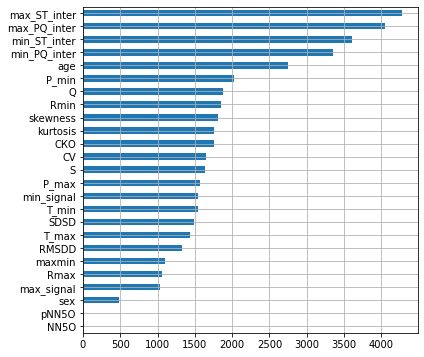

In [ ]:
rf = Pipeline([('rf', LGBMClassifier())])
# важность признаков
plot_features_scores(model=rf, data=X_train, target=y_train, column_names=X.columns, model_type='rf')

In [ ]:
selector = GenericUnivariateSelect(score_func=mutual_info_classif, 
                                   mode='k_best', 
                                   param=20)
# применим к нашему датасету
selector.fit(X_train, y_train)
# метод transform вернёт массив с отобранными признаками
# выведем результаты оценки каждого признака 
(pd.DataFrame(data={'score':selector.scores_,
                   'support':selector.get_support()}, 
             index=X.columns).sort_values(by='score',ascending=False)).to_csv("/content/sample_data/"+"lis"+".csv")
lis = pd.read_csv("/content/sample_data/"+"lis"+".csv")
lis

,Unnamed: 0,score,support
0,max_ST_inter,0.581884,True
1,max_PQ_inter,0.417709,True
2,min_ST_inter,0.312621,True
3,min_PQ_inter,0.268299,True
4,age,0.240008,True
5,RMSDD,0.184245,True
6,SDSD,0.180043,True
7,СКО,0.157435,True
8,CV,0.142791,True
9,T_min,0.111131,True


In [ ]:
def obrabotka1(X, y):
  model=LGBMClassifier()
  sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
  X, y = sm.fit_resample(X, y)
  sm = BorderlineSMOTE(random_state=42)
  X, y = sm.fit_resample(X, y)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)#test_size=0.3 # random_state=1235
  model.fit(X_train, y_train)
  # предсказываем
  row = X_valid
  yhat = model.predict(row)
  y_predict = model.predict(X_valid)
  df_c_100 = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
  report = metrics.classification_report(y_valid, y_predict, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]) #precision, recall, f1-score,etc
  print(report)
  print(model.score(X_train, y_train))



In [ ]:
lis1 = list(lis["Unnamed: 0"])[:24]
X, y = dp[lis1] , dp['scp_codes']
obrabotka1(X, y)

              precision    recall  f1-score   support

           0       0.46      0.72      0.56      2672
           1       0.79      0.41      0.54      2542
           2       0.86      0.63      0.73      2594
           3       0.85      0.71      0.77      2621
           4       0.87      0.80      0.84      2676
           5       0.92      0.86      0.89      2569
           6       0.91      0.93      0.92      2717
           7       0.90      0.95      0.92      2592
           8       0.91      0.96      0.93      2574
           9       0.81      0.94      0.87      2687
          10       0.92      0.95      0.93      2695
          11       0.95      0.94      0.95      2653
          12       0.94      0.98      0.96      2602
          13       0.92      0.98      0.95      2618
          14       0.97      0.98      0.97      2653

    accuracy                           0.85     39465
   macro avg       0.86      0.85      0.85     39465
weighted avg       0.86   

In [ ]:
lis1 = list(lis["Unnamed: 0"])[:23]
X, y = dp[lis1] , dp['scp_codes']
obrabotka1(X, y)

              precision    recall  f1-score   support

           0       0.46      0.72      0.56      2672
           1       0.78      0.42      0.54      2542
           2       0.85      0.62      0.72      2594
           3       0.86      0.72      0.78      2621
           4       0.88      0.81      0.84      2676
           5       0.91      0.86      0.88      2569
           6       0.91      0.94      0.92      2717
           7       0.89      0.95      0.92      2592
           8       0.92      0.96      0.94      2574
           9       0.80      0.94      0.87      2687
          10       0.93      0.95      0.94      2695
          11       0.95      0.95      0.95      2653
          12       0.95      0.98      0.96      2602
          13       0.92      0.98      0.95      2618
          14       0.97      0.98      0.98      2653

    accuracy                           0.85     39465
   macro avg       0.87      0.85      0.85     39465
weighted avg       0.87   

In [ ]:
lis1 = list(lis["Unnamed: 0"])[:22]
X, y = dp[lis1] , dp['scp_codes']
obrabotka1(X, y)

              precision    recall  f1-score   support

           0       0.45      0.71      0.55      2672
           1       0.81      0.40      0.53      2542
           2       0.84      0.62      0.71      2594
           3       0.84      0.70      0.76      2621
           4       0.87      0.82      0.84      2676
           5       0.89      0.86      0.87      2569
           6       0.91      0.94      0.92      2717
           7       0.90      0.95      0.92      2592
           8       0.90      0.96      0.93      2574
           9       0.81      0.94      0.87      2688
          10       0.93      0.95      0.94      2694
          11       0.94      0.94      0.94      2653
          12       0.95      0.98      0.96      2602
          13       0.92      0.98      0.95      2618
          14       0.97      0.98      0.98      2653

    accuracy                           0.85     39465
   macro avg       0.86      0.85      0.85     39465
weighted avg       0.86   

## Сократим модель с помощью функций // подает точность

До удалении последнего столбца судя по всему происходит переобучение .

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel


X, y = dp.drop(columns=['scp_codes']) , dp['scp_codes']
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
X=X_new
obrabotka1(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


              precision    recall  f1-score   support

           0       0.46      0.71      0.56      2672
           1       0.80      0.39      0.53      2542
           2       0.84      0.62      0.71      2594
           3       0.85      0.70      0.77      2621
           4       0.87      0.81      0.84      2676
           5       0.89      0.85      0.87      2569
           6       0.90      0.93      0.92      2717
           7       0.89      0.95      0.92      2592
           8       0.90      0.96      0.93      2574
           9       0.80      0.94      0.87      2688
          10       0.92      0.95      0.94      2694
          11       0.94      0.95      0.94      2653
          12       0.95      0.98      0.96      2602
          13       0.92      0.98      0.95      2618
          14       0.97      0.98      0.98      2653

    accuracy                           0.85     39465
   macro avg       0.86      0.85      0.84     39465
weighted avg       0.86   

In [ ]:
#X, y = dp.drop(columns=['scp_codes']) , dp['scp_codes']
from sklearn.feature_selection import VarianceThreshold
X, y = dp.drop(columns=['scp_codes']) , dp['scp_codes']
selector = VarianceThreshold()
X = selector.fit_transform(X)
obrabotka1(X, y)

              precision    recall  f1-score   support

           0       0.46      0.76      0.57      2672
           1       0.80      0.42      0.55      2542
           2       0.86      0.63      0.72      2594
           3       0.87      0.72      0.79      2621
           4       0.88      0.81      0.84      2676
           5       0.90      0.86      0.88      2569
           6       0.91      0.94      0.92      2717
           7       0.90      0.95      0.93      2592
           8       0.93      0.96      0.94      2574
           9       0.83      0.94      0.88      2687
          10       0.92      0.95      0.93      2695
          11       0.95      0.94      0.95      2653
          12       0.95      0.98      0.97      2602
          13       0.94      0.98      0.96      2618
          14       0.98      0.98      0.98      2653

    accuracy                           0.86     39465
   macro avg       0.87      0.85      0.85     39465
weighted avg       0.87   

## Кросс-валидация

In [18]:
import sklearn as sk
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score

In [13]:

dp = pd.read_csv("/content/gdrive/MyDrive/data/"+"df_1_1.1"+".csv").drop(columns =["Unnamed: 0"], axis = 1)
dp= dp.dropna()

X, y = dp.drop(columns=['scp_codes']) , dp['scp_codes']
sm = KMeansSMOTE(random_state=42,cluster_balance_threshold = 0.01)
X1, y1 = sm.fit_resample(X, y)
sm = BorderlineSMOTE(random_state=42)
X1, y1 = sm.fit_resample(X1, y1)
X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, test_size=0.3, random_state=0)#test_size=0.3 # random_state=1235

In [16]:
model=LGBMClassifier()

In [ ]:
scores = cross_val_score(model, X1, y1, cv=5)
scores

array([0.66822501, 0.8781832 , 0.90820981, 0.90733561, 0.84747244])

In [19]:
scores = cross_val_score(model, X1, y1, cv=5)
scores

array([0.66822501, 0.8781832 , 0.90820981, 0.90733561, 0.84747244])

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.84 accuracy with a standard deviation of 0.09


In [20]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.84 accuracy with a standard deviation of 0.09


In [ ]:
scoring = ['precision_macro', 'recall_macro']
clf = LGBMClassifier()
scores = cross_validate(clf, X1, y1, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([57.23968172, 27.70727968, 28.0592649 , 28.97997212, 29.57196259]),
 'score_time': array([2.40549135, 3.28551674, 2.48369956, 2.40286779, 2.41883755]),
 'test_precision_macro': array([0.83171091, 0.87195477, 0.9086285 , 0.90801616, 0.85475473]),
 'test_recall_macro': array([0.66822501, 0.8781832 , 0.90820981, 0.90733561, 0.84747244])}

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores["test_precision_macro"].mean(), scores["test_precision_macro"].std()))

0.88 accuracy with a standard deviation of 0.03


In [21]:
scoring = ['precision_macro', 'recall_macro']
clf = LGBMClassifier()
scores = cross_validate(clf, X1, y1, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([36.29680991, 36.48923039, 36.72317791, 36.78615761, 35.89366579]),
 'score_time': array([3.5365622 , 3.68984127, 3.79250765, 3.7091279 , 3.76702619]),
 'test_precision_macro': array([0.83171091, 0.87195477, 0.9086285 , 0.90801616, 0.85475473]),
 'test_recall_macro': array([0.66822501, 0.8781832 , 0.90820981, 0.90733561, 0.84747244])}

In [22]:
print("%0.2f recall with a standard deviation of %0.2f" % (scores["test_precision_macro"].mean(), scores["test_precision_macro"].std()))

0.88 recall with a standard deviation of 0.03


In [ ]:
from sklearn.model_selection import (
    TimeSeriesSplit,
    KFold,
    ShuffleSplit,
    StratifiedKFold,
    GroupShuffleSplit,
    GroupKFold,
    StratifiedShuffleSplit,
    StratifiedGroupKFold,
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

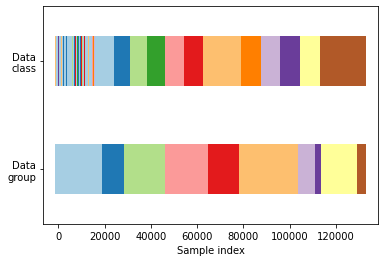

In [ ]:
X=X1
y=y1
# Generate uneven groups
group_prior = rng.dirichlet([2] * 10)
groups = np.repeat(np.arange(10), rng.multinomial(131550, group_prior))


def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(range(len(groups)),[0.5] * len(groups),c=groups,marker="_",lw=50,cmap=cmap_data,)
    ax.scatter(range(len(groups)),[3.5] * len(groups),c=classes,marker="_",lw=50,cmap=cmap_data,)
    ax.set(ylim=[-1, 5],yticks=[0.5, 3.5],yticklabels=["Data\ngroup", "Data\nclass"],xlabel="Sample index",)


visualize_groups(y, groups, "no groups")

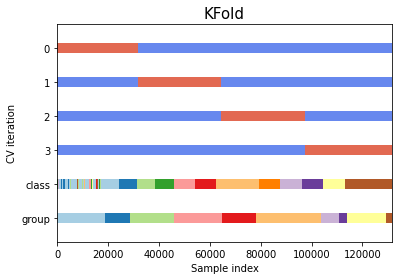

In [ ]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
    ax.scatter(range(len(indices)),[ii + 0.5] * len(indices),c=indices,marker="_",lw=lw,cmap=cmap_cv,vmin=-0.2,vmax=1.2,)
        # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data)
    ax.scatter(range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data)
 # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(yticks=np.arange(n_splits + 2) + 0.5,yticklabels=yticklabels,xlabel="Sample index",ylabel="CV iteration",ylim=[n_splits + 2.2, -0.2],xlim=[0, 131550],)
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, X, y, groups, ax, n_splits)

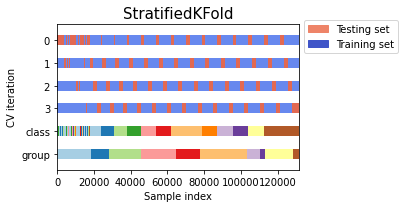

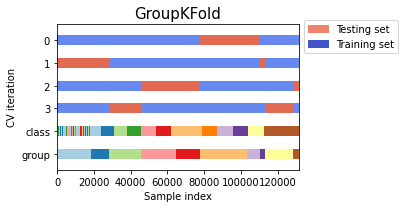

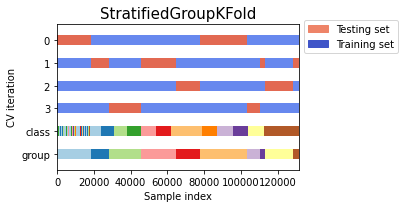

In [ ]:
cvs = [StratifiedKFold, GroupKFold, StratifiedGroupKFold]

for cv in cvs:
    fig, ax = plt.subplots(figsize=(6, 3))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits)
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
